# Data Scientist Associate Case Study (Modified)

## Company Background
GoalZone is a fitness club chain providing five types of fitness classes in Canada. Finally, the fitness classes schedule is back to normal after the COVID-19 restrictions are lifted. However, they have received many complaints from the customers about having a hard time booking a fitness class.

From initial analysis, the program operation team found out that the fitness classes are always fully booked but are having a low attendance rate per class. To improve this situation, they would like to increase the class capacity for customers to sign up if a low attendance rate is predicted.  


## Customer Question
The operation manager has asked you to answer the following:
- Can you predict the attendance rate for each fitness class? 



## Dataset
The dataset contains the attendance information for the class scheduled this year so far. The data you will use for this analysis can be accessed here: `"data/fitness_class.csv"`

| Column Name                     | Criteria                                                                                                                                                                        |
|---------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Day of Week                     | Character, the day of the week the class was scheduled, one of values from “Mon” to “Sun”.                                                                                      |
| Time                            | Character, the time of the day the class was scheduled, either "AM" or "PM".                                                                                                        |
| Class Category                  | Character, the category of the fitness class, one of “Yoga”, “Aqua”, “Strength”, “HIIT”, or “Cycling”.                                                                          |
| Days Before                     | Numeric, number of days the class stayed fully booked, maximum five days.                                                                                                       |
| Class Capacity                  | Numeric, maximum number of members can sign up for that class, either 15 or 25.                                        |
| Attendance                      | Numeric, number of members actually attended the class.                                                                                                                         |
| Average Age                     | Numeric, average age of the members signing up for that class.  (Group fitness class are for members aged 14 and older.)  |
| Number of New Students          | Numeric, number of new students signing up for this class.                                                                                                                      |
| Number of Members Over 6 months | Numeric, number of members signing up for the class have been joining the club more than 6 months.                                                                              |                                                                                     |

## 1. Data Validation
- Import the data from .csv file.
- Perform data cleaning and validation to make sure that the data is ready for analysis.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [2]:
# Import CSV file to dataframe
fitness_df = pd.read_csv('data/fitness_class.csv')
# Inspect some first rows of the dataset
fitness_df.head()

,day_of_week,time,class_category,class_capacity,days_before,attendance,age,new_students,over_6_month
0,Wed,AM,Yoga,15,1,8,31.1,6,4
1,Sun,PM,Aqua,15,3,8,27.0,7,8
2,Mon,AM,Aqua,15,5,10,22.4,8,7
3,Sun,PM,Strength,25,3,18,23.5,7,9
4,Mon,AM,Yoga,15,5,10,29.8,5,7


In [3]:
# General information about the dataset
fitness_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 765 entries, 0 to 764
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   day_of_week     765 non-null    object 
 1   time            765 non-null    object 
 2   class_category  765 non-null    object 
 3   class_capacity  765 non-null    int64  
 4   days_before     765 non-null    int64  
 5   attendance      765 non-null    int64  
 6   age             765 non-null    float64
 7   new_students    765 non-null    int64  
 8   over_6_month    765 non-null    int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 53.9+ KB


In [4]:
# The number of rows and columns
print('The dataset contains: {} rows, {} columns'.format(fitness_df.shape[0],fitness_df.shape[1]))

The dataset contains: 765 rows, 9 columns


In [5]:
# The data type in each column
fitness_df.dtypes

day_of_week        object
time               object
class_category     object
class_capacity      int64
days_before         int64
attendance          int64
age               float64
new_students        int64
over_6_month        int64
dtype: object

In [6]:
# Number of unique values
fitness_df.nunique()

day_of_week         7
time                2
class_category      5
class_capacity      3
days_before         5
attendance         18
age               234
new_students       11
over_6_month       12
dtype: int64

In [7]:
# Check for duplicated value
print('There is {} duplicated rows.'.format(fitness_df.duplicated().sum()))

There is 0 duplicated rows.


In [8]:
# Check for missing values
fitness_df.isna().sum()

day_of_week       0
time              0
class_category    0
class_capacity    0
days_before       0
attendance        0
age               0
new_students      0
over_6_month      0
dtype: int64

#### Class capacity
- It can be seen from the validation that the column 'class_capacity' has 3 unique value.
- Since there is only class for 15 or 25 people, this column is not corresponding to data quality in term of accuracy and needed to be cleaned.

In [9]:
# Check the column 'class_capacity'
fitness_df['class_capacity'].value_counts()

15    571
25    189
26      5
Name: class_capacity, dtype: int64

- The data collector inform that in some rows, the data is mislabeled from 25 to 26. Therefore, the value 26 should be changed back to 25.

In [10]:
# Update the column 'class_capacity'
fitness_df['class_capacity'] = fitness_df['class_capacity'].replace(26, 25)

# Recheck
fitness_df['class_capacity'].value_counts()

15    571
25    194
Name: class_capacity, dtype: int64

#### Age
- The age of the members attended the class must not less than 14 years.
- The column 'Age' is checked and the number of minimum of the value is less than 14.

In [11]:
# Check the column 'Age'
print('The minimum average age of the members is {}'.format(fitness_df['age'].min()))

The minimum average age of the members is 8.3


In [12]:
misinformed = fitness_df[fitness_df['age'] < 14].shape[0]
print('There are {} misinformed rows from {} rows.'.format(misinformed, fitness_df.shape[0]))

There are 3 misinformed rows from 765 rows.


- Since there are less than 5% proportion of misinformed row, they can be removed from the dataset.

In [13]:
# Remove the observations where the average age is smaller than 14
# In other word, subset for only rows with the average age greater than 14
fitness_df = fitness_df[fitness_df['age'] >= 14]
# Recheck
print('The minimum average age of the members should be {}'.format(fitness_df['age'].min()))

The minimum average age of the members should be 14.0


In [14]:
fitness_df['attendance_rate'] = fitness_df['attendance']/fitness_df['class_capacity']

In [15]:
# The number of rows and columns AFTER CLEANING
print('The dataset contains: {} rows, {} columns'.format(fitness_df.shape[0],fitness_df.shape[1]))

The dataset contains: 762 rows, 10 columns


**OBSERVATION**
- The imported dataset contains 765 rows, 9 columns.
- Among 9 columns, there are 6 numerical and 3 categorical variables.
- There is neither the missing values nor the duplicated rows.
**CLEANING/VALIDATING TASK**
- Replaced the misinformation data in the column 'class_capacity'.
- Removed the row in the column 'age' which has a value less than 14.
- Performed the data manipulation, by adding the column 'attendance_rate' as the target column.
- The cleaned dataset contains 762 rows, 10 columns.

## 2. Exploratory Data Analysis
- Perform EDA and Data Visualization to describe the characteristic of each feature.
- Perform EDA and Data Visualization to describe the relationship between each pair of features.

#### Attendance Rate
- The operation manager want to know about the attendance rate.
- Since the attendance rate is the target of this projectadd the 'attendance_rate' column.

In [16]:
# Display the summary statistics of each column
fitness_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
class_capacity,762.0,17.506562,4.336755,15.000000,15.0,15.000000,22.500000,25.00
days_before,762.0,2.547244,1.355768,1.000000,1.0,2.000000,4.000000,5.00
attendance,762.0,9.519685,3.841164,4.000000,7.0,9.000000,11.000000,21.00
age,762.0,29.163648,5.812547,14.000000,25.3,29.000000,33.200000,48.80
new_students,762.0,5.912073,1.788821,1.000000,5.0,6.000000,7.000000,11.00
over_6_month,762.0,7.565617,1.968617,2.000000,6.0,8.000000,9.000000,13.00
attendance_rate,762.0,0.542152,0.162767,0.266667,0.4,0.533333,0.666667,0.84


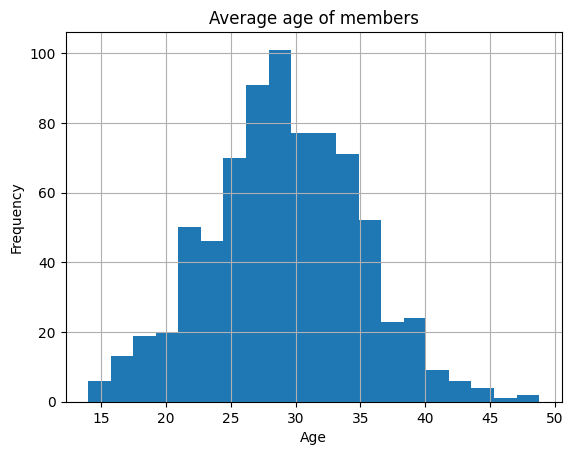

In [17]:
# Plot the HISTOGRAM of the age of the members
fitness_df['age'].hist(bins=20)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Average age of members')
plt.show()

In [18]:
# The proportion of each class category
print(fitness_df['class_category'].value_counts(normalize=True))

Yoga        0.227034
Strength    0.212598
Aqua        0.209974
HIIT        0.179790
Cycling     0.170604
Name: class_category, dtype: float64


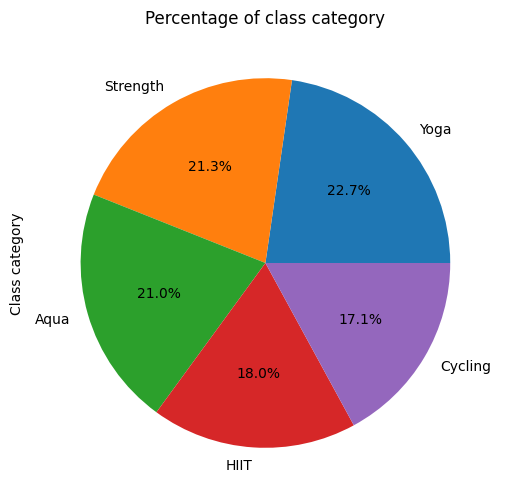

In [19]:
# Plot the PIE CHART to see the proportion of each class category
ax = fitness_df['class_category'].value_counts().plot.pie(autopct = '%1.1f%%', figsize=(8, 6))
ax.set(ylabel = 'Class category', title = 'Percentage of class category')
plt.show()

In [20]:
# The proportion of class by time
time_by_day = fitness_df.groupby('day_of_week')['time'].value_counts(normalize=True)
time_by_day_wide = time_by_day.unstack().loc[['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']]
print(time_by_day_wide)

time               AM        PM
day_of_week                    
Mon          0.413043  0.586957
Tue          0.483333  0.516667
Wed          0.465517  0.534483
Thu          0.492063  0.507937
Fri          0.425532  0.574468
Sat          0.484848  0.515152
Sun          0.582609  0.417391


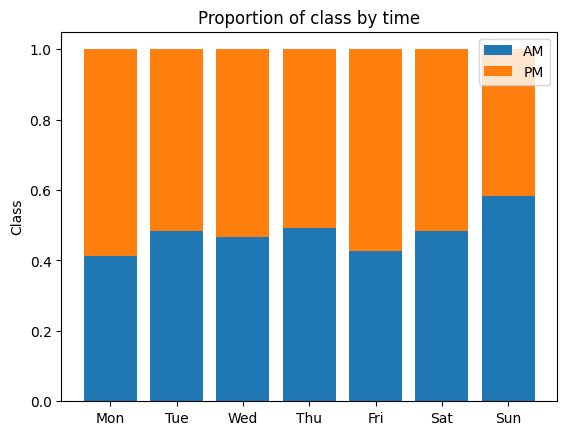

In [21]:
# Plot the STACKED BAR CHART to see the proportion of class by time
fig, ax = plt.subplots()
ax.bar(time_by_day_wide.index, time_by_day_wide['AM'], label='AM')
ax.bar(time_by_day_wide.index, time_by_day_wide['PM'], label='PM', bottom=time_by_day_wide['AM'])
ax.set(ylabel='Class', title='Proportion of class by time')
ax.legend()
plt.show()

In [22]:
# The number of total members attended by day
attendance_by_day = fitness_df.groupby('day_of_week')['attendance'].sum()
print(attendance_by_day.sort_values(ascending=False))

day_of_week
Tue    1189
Thu    1142
Sun    1139
Wed    1102
Sat     909
Fri     905
Mon     868
Name: attendance, dtype: int64


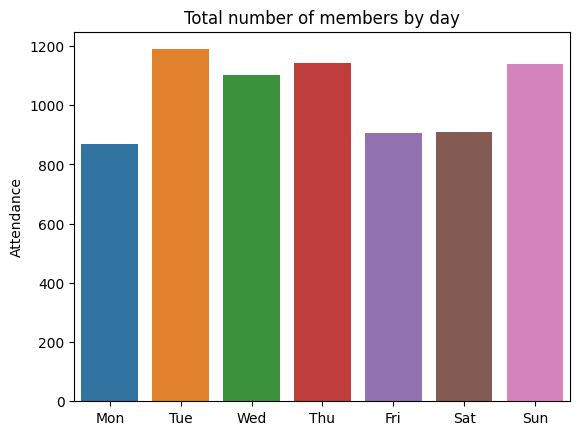

In [23]:
# Plot the BAR CHART to display the number of total members attended by day
ax = sns.barplot(x=attendance_by_day.index, y=attendance_by_day, order=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
ax.set(xlabel='', ylabel='Attendance', title='Total number of members by day')
plt.show()

In [24]:
# Total members attended by day
attendance_rate_by_day = fitness_df.groupby('day_of_week')['attendance_rate'].mean()
print(attendance_rate_by_day.sort_values())

day_of_week
Mon    0.528116
Thu    0.535450
Sun    0.539478
Wed    0.539770
Fri    0.540851
Sat    0.549091
Tue    0.560111
Name: attendance_rate, dtype: float64


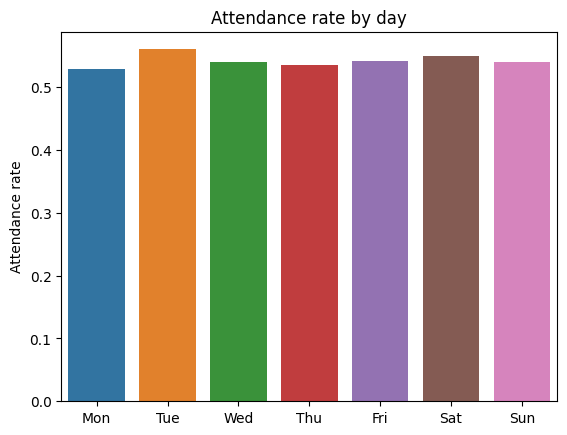

In [25]:
# Plot the BAR CHART to display the number of total members attended by day
ax = sns.barplot(x=attendance_rate_by_day.index, y=attendance_rate_by_day, order=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
ax.set(xlabel='', ylabel='Attendance rate', title='Attendance rate by day')
plt.show()

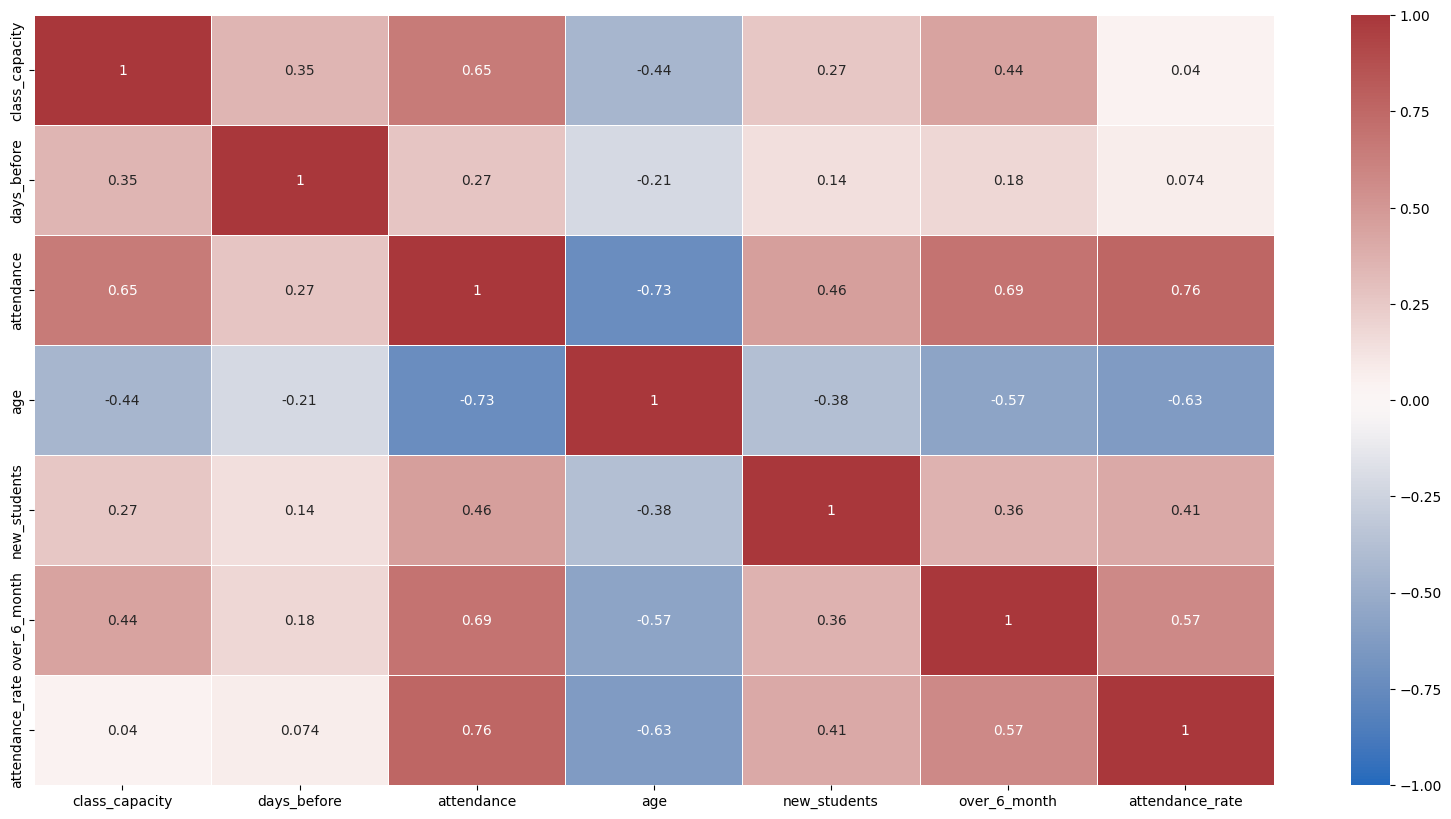

In [26]:
# Plot the HEATMAP to observe the correlation between pairs of numerical variables
plt.figure(figsize=[20, 10])
sns.heatmap(fitness_df.corr(), annot=True, linewidths=0.5, vmin=-1, vmax=1, cmap='vlag')
plt.show()

**SUMMARY**
- According to the histogram, the age of the members is within the range of 14 to 49 years with the average of 29 years old.
- According to the pie chart, Yoga is the most popular among all classes.
- According to the stacked bar chart, people often attend the class in the afternoon rather than in the morning except on Sunday.
- According to the second bar chart, members most likely attend the class on Tuesday.
- According to the third bar chart, Monday is the day with the smallest attendance rate.
- According to the heatmap, we cen tell that aside from the correlation between attendance and attendance rate, there is a moderately strong negative relationship between the average age of the class and the attendance rate and a moderately strong positive relationship between number of more than 6-year membership members and the attendance rate.

## 3. Preprocess the data
- Prepare the data for modeling phase.

In [27]:
# Encode the categorical variables to number
fitness_dummies = pd.get_dummies(fitness_df)
# drop one dummy variable for binary-class
fitness_dummies.drop('time_PM', axis=1, inplace=True)
print('Dummies dataframe shape: {}'.format(fitness_dummies.shape))

Dummies dataframe shape: (762, 20)


In [28]:
# Create features and target array for train the model
X = fitness_dummies.drop('attendance', axis=1).values.astype(float)
y = fitness_dummies['attendance'].values.astype(float)

In [29]:
# Split the dataset to training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_test shape: {}'.format(X_test.shape))
print('y_test shape: {}'.format(y_test.shape))

X_train shape: (609, 19)
y_train shape: (609,)
X_test shape: (153, 19)
y_test shape: (153,)


In [30]:
# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**PREPROCESS THE DATA**
- Encoded the categorical variables to numeric.
- Selected features and targets assigned to arrays, changed the data type to 'float64'.
- Splited the dataset to training set and test set.
- Performed the standardization to scaling the data to the same range.

## 4. Model Fitting
- Train different Machine Learning model using the preprocessed data.
- The model used for training:
	- Ridge Regression
    - K-Nearest Neighbors
    - Random Forest
    - Extreme Gradient Boosting Tree
- The metrics used for evaluation:
	- R2
    - RMSE

In [31]:
## Model 1 (RIDGE REGRESSION)
# Perform 5-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=20)
# Hyperparameters
param_grids = {"alpha": [0.00001, 0.00003, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]}
# Initialize the model
ridge_model = Ridge()
# Hyperparameter tuning using GridSearchCV
ridge_model_cv = GridSearchCV(ridge_model, param_grids, cv=kf)
# Fit the model
ridge_model_cv.fit(X_train_scaled, y_train)
print('The best parameters: {}'.format(ridge_model_cv.best_params_)) 

The best parameters: {'alpha': 1}


In [34]:
## Model 2 (K-Nearest Neighbors)
# Perform 5-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=20)
# Hyperparameters
param_grids = {"n_neighbors": range(3, 51)}
# Initialize the model
knn_model = KNeighborsRegressor()
# Hyperparameter tuning using GridSearchCV
knn_model_cv = GridSearchCV(knn_model, param_grids, cv=kf)
# Fit the model
knn_model_cv.fit(X_train_scaled, y_train)
print('The best parameters: {}'.format(knn_model_cv.best_params_)) 

The best parameters: {'n_neighbors': 26}


In [35]:
## Model 3 (Random Forest)
# Perform 5-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=20)
# Hyperparameters
param_grids = {}
# Initialize the model
rf_model = RandomForestRegressor()
# Hyperparameter tuning using GridSearchCV
rf_model_cv = GridSearchCV(rf_model, param_grids, cv=kf)
# Fit the model
rf_model_cv.fit(X_train_scaled, y_train)
print('The best parameters: {}'.format(rf_model_cv.best_params_)) 

The best parameters: {}


In [36]:
## Model 4 (Extreme Gradient Boosting Tree)
# Perform 5-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=20)
# Hyperparameters
param_grids = {}
# Initialize the model
xgb_model = XGBRegressor()
# Hyperparameter tuning using GridSearchCV
xgb_model_cv = GridSearchCV(xgb_model, param_grids, cv=kf)
# Fit the model
xgb_model_cv.fit(X_train_scaled, y_train)
print('The best parameters: {}'.format(xgb_model_cv.best_params_)) 

The best parameters: {}


**EXPLANATION**
- The objective of this work is to predict the attendance rate which is the numerical variable. Hence, this project is a regression problem.
- Ridge Regression, K-Nearest Neighbor, Random Forest, and Extreme Gradient Boosting Tree are used for training the data.
- R2, RMSE are used as metrics for evaluation.
- 5-Fold Cross Validation is also performed to prevent overfitting on the training set.
- In the first and second model, performed the hyperparameter tuning using GridSearchCV to find the optimal hyperparameter which yields the model with the highest accuracy.

## 5. Model Evaluation
- Evaluate and choose the model with the best performance.

In [37]:
# Model Evaluation: RIDGE MODEL
y_pred_ridge = ridge_model_cv.predict(X_test_scaled)
print('RIDGE MODEL')
print('R-squared = {}'.format(ridge_model_cv.score(X_test_scaled, y_test)))
print('RMSE = {}\n'.format(mean_squared_error(y_test, y_pred_ridge, squared=False)))

# Model Evaluation: K-NEAREST NEIGHBORS MODEL
y_pred_knn = knn_model_cv.predict(X_test_scaled)
print('K-NEAREST NEIGHBORS MODEL')
print('R-squared = {}'.format(knn_model_cv.score(X_test_scaled, y_test)))
print('RMSE = {}\n'.format(mean_squared_error(y_test, y_pred_knn, squared=False)))

# Model Evaluation: RANDOM FOREST MODEL
y_pred_rf = rf_model_cv.predict(X_test_scaled)
print('RANDOM FOREST MODEL')
print('R-squared = {}'.format(rf_model_cv.score(X_test_scaled, y_test)))
print('RMSE = {}\n'.format(mean_squared_error(y_test, y_pred_rf, squared=False)))

# Model Evaluation: XGBOOST MODEL
y_pred_xgb = xgb_model_cv.predict(X_test_scaled)
print('XGBOOST MODEL')
print('R-squared = {}'.format(xgb_model_cv.score(X_test_scaled, y_test)))
print('RMSE = {}\n'.format(mean_squared_error(y_test, y_pred_xgb, squared=False)))

RIDGE MODEL
R-squared = 0.9677747863405523
RMSE = 0.6456075935969844

K-NEAREST NEIGHBORS MODEL
R-squared = 0.6801394530435153
RMSE = 2.0340005448238543

RANDOM FOREST MODEL
R-squared = 0.9999988377623209
RMSE = 0.003877199986918672

XGBOOST MODEL
R-squared = 0.9999995223802423
RMSE = 0.0024854891358144135



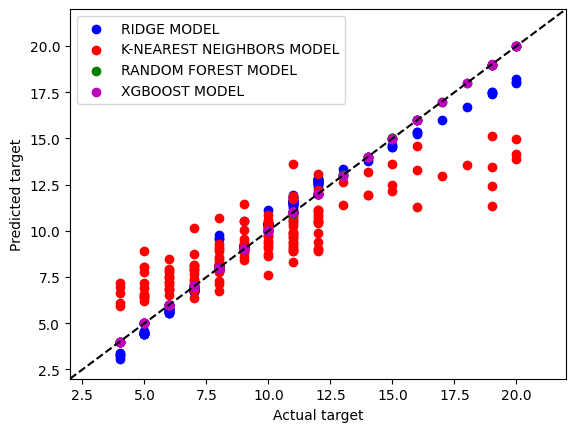

In [43]:
# Plot the actual target of the test data compared with predicted target for all models
plt.scatter(y_test, y_pred_ridge, color='b')
plt.scatter(y_test, y_pred_knn, color='r')
plt.scatter(y_test, y_pred_rf, color='g')
plt.scatter(y_test, y_pred_xgb, color='m')

plt.plot([min(y_test)-2, max(y_test)+2], [min(y_test)-2, max(y_test)+2],'k--')
plt.axis([min(y_test)-2, max(y_test)+2, min(y_test)-2, max(y_test)+2])
plt.xlabel('Actual target')
plt.ylabel('Predicted target')
plt.legend(['RIDGE MODEL', 'K-NEAREST NEIGHBORS MODEL', 'RANDOM FOREST MODEL', 'XGBOOST MODEL'])
plt.show()

**EXPLANATION**
- The R-squared score and RMSE is chosen as metrics for evaluating both models since both of them are measures how close the actual output and the predicted output are. They are common metrics used to evaluate the supervised model in the regression problem.
- The scatter plot of Actual target vs Predicted target shows the accuracy of all 4 models. You can see that the plot is very close to an ideal black-dotted line(R-squared = 1).
- According to the evaluation results, both the Random Forest and XGBoost model performed well and achieved very high accuracy. Ridge Regression model has moderately satisfying accuracy whereas K-nearest Neighbor model yields high error.
- It is concluded that both the Random Forest and XGBoost model have better performance and would likely to be the better approach for predicting the attendance rate for each fitness class. However, Ridge Regression model can also be a good alternative approach since its performance is acceptable and its accuracy is not far behind compared to Random Forest and XGBoost model.